In [157]:
# import libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# !pip install folium # uncomment to install folium
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

print('Import done')

Import done


In [2]:
# read csv file
global_terror = pd.read_csv('globalterrorismdb.csv',sep=',',encoding = "ISO-8859-1")

C:\Users\daniel.czwalinna\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# drop empty rows and columns
global_terror.dropna(inplace=True, how='all')
global_terror.dropna(inplace=True, how='all', axis=1)

# overview of imported dataframe
print(global_terror.shape)
global_terror.head()

(181691, 135)


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [69]:
# create clean data frame without incidents marked with doubt and drop column
gt_clean = global_terror[global_terror.doubtterr == 0].copy()
gt_clean.drop(['doubtterr'], axis=1, inplace=True)
gt_clean.shape

(138905, 134)

In [412]:
# filter for incidents between (including) 1970 and 2017, create df that counts amount of unique weapons used incl. their percentag of total
weaptype_count = gt_clean[(gt_clean.iyear > 1969) & (gt_clean.iyear < 2018)]
weaptype_count = weaptype_count['weaptype1_txt'].value_counts()
weaptype_count = pd.DataFrame(weaptype_count)
weaptype_count.reset_index(inplace=True)
weaptype_count.columns = ['Weapon Type', 'Attack Count']

# add percentage column
weaptype_count['Percent'] = weaptype_count['Attack Count'] / weaptype_count['Attack Count'].sum() * 100
weaptype_count['Percent'] = weaptype_count['Percent'].round(2)

# clean Weapon Type values
temp_df = weaptype_count['Weapon Type'].str.split('(', expand=True)
weaptype_count['Weapon Type'] = temp_df[0]
weaptype_count

,Weapon Type,Attack Count,Percent
0,Explosives,77363,55.69
1,Firearms,40649,29.26
2,Unknown,9896,7.12
3,Incendiary,7875,5.67
4,Melee,2487,1.79
5,Chemical,274,0.20
6,Sabotage Equipment,129,0.09
7,Other,95,0.07
8,Vehicle,81,0.06
9,Biological,31,0.02


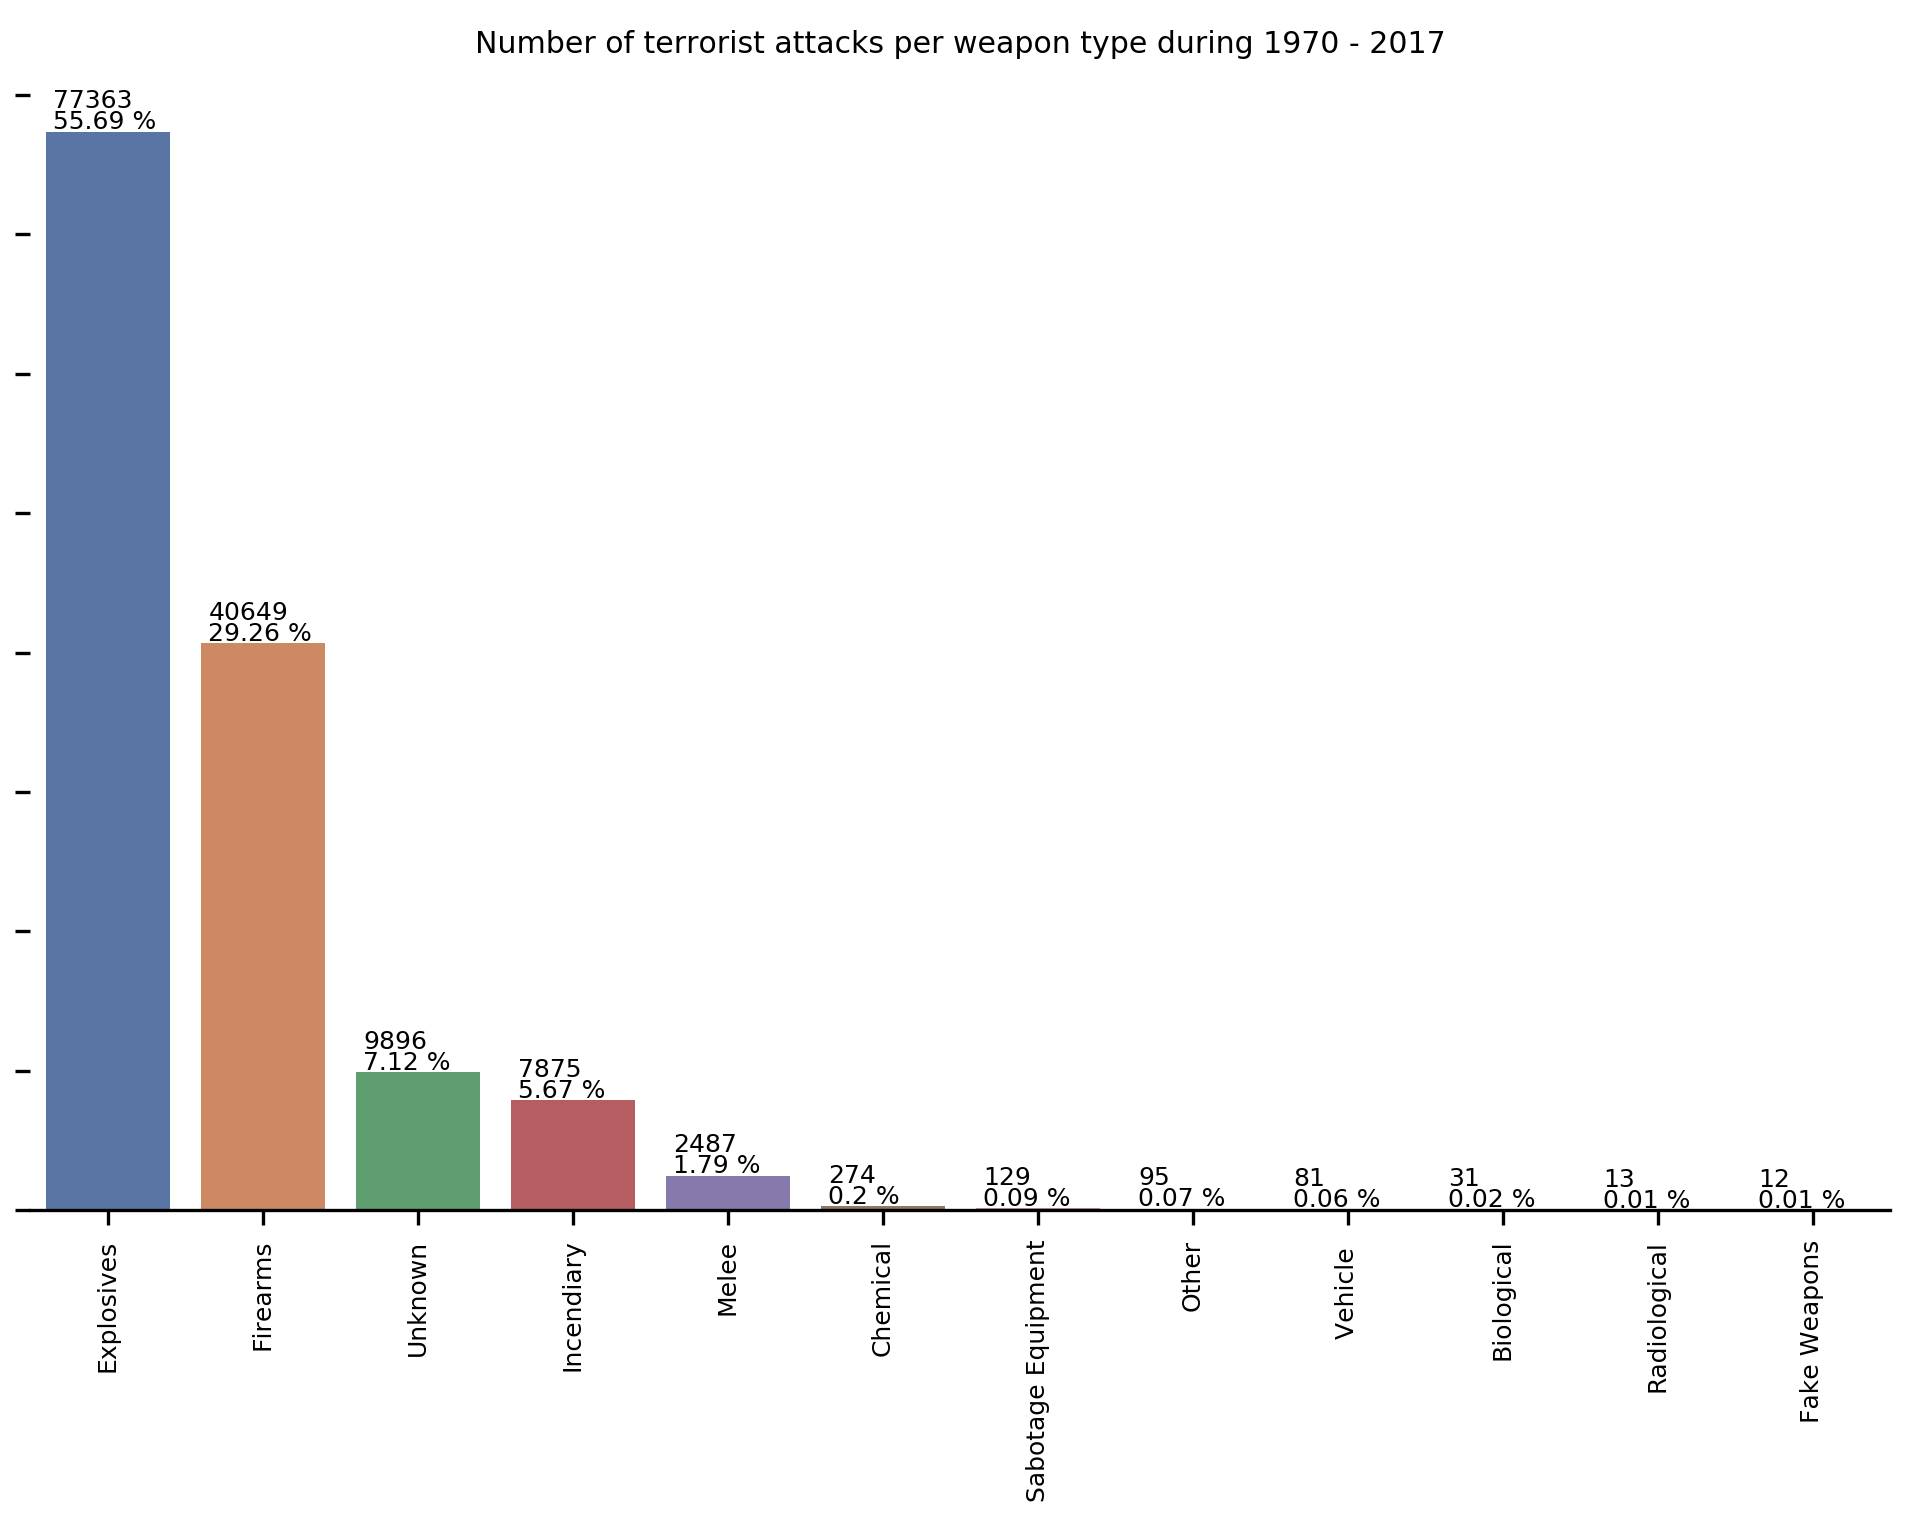

In [424]:
# create chart showing number of attacks per weapon type
X = np.arange(12)

fig, ax = plt.subplots(figsize = (8, 5), dpi=300)
plt.rcParams.update({'font.size': 6})

sns.barplot(data=weaptype_count, x='Weapon Type', y='Attack Count', palette='deep')
plt.xticks(rotation=90)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_title('Number of terrorist attacks per weapon type during 1970 - 2017')

# add annotation
for s, d in zip(X, weaptype_count['Attack Count']):
    plt.annotate(weaptype_count['Attack Count'][s], xy = (s-0.35,d+1700), color='black')
for s, d in zip(X, weaptype_count['Attack Count']):
    plt.annotate(str(weaptype_count['Percent'][s]) + ' %', xy = (s-0.35,d+200), color='black')

plt.savefig('attacks_per_weapon_type.png', dpi=300)

In [416]:
# create list with weapon type and borders for decades
weaptype_filter = weaptype_count['Weapon Type'].unique()
year_border = [[1969,1980],[1979,1990],[1989,2000],[1999,2010],[2009,2018]]

In [417]:
# create heat map per loop for each weapon type and each decade respectively
base_map = folium.Map(location=[31.757364,14.693972], zoom_start=1.5)

weapon_trend = []

for weapon in weaptype_filter:
    for low, high in year_border:
        gt_for_htmap = gt_clean[(gt_clean['weaptype1_txt'] == weapon) & (gt_clean.iyear > low) & (gt_clean.iyear < high)][['latitude', 'longitude']].copy()
        gt_for_htmap['count'] = 1
        gt_for_htmap.dropna(inplace=True)
        
        # create list with total numbers of attacks per decade per weapon used - for later visualization
        item = [str(weapon), (str(low+1) + '-' + str(high-1)), int(gt_for_htmap.shape[0])]
        weapon_trend.append(item)
        
        HeatMap(data=gt_for_htmap[['latitude','longitude', 'count']].groupby(['latitude', 'longitude', 'count']).sum().reset_index().values.tolist(), radius=8).add_to(base_map)
        base_map.save(f'Heatmap_{str(weapon)}_{low+1}-{high-1}.html')
        
        print(f'{weapon:} {low+1}-{high-1} {gt_for_htmap.shape}')

weapon_trend = pd.DataFrame(weapon_trend, columns=['Weapon Type', 'Decade', 'Attack Count'])

Explosives 1970-1979 (3517, 3)
Explosives 1980-1989 (10638, 3)
Explosives 1990-1999 (8314, 3)
Explosives 2000-2009 (12409, 3)
Explosives 2010-2017 (41337, 3)
Firearms 1970-1979 (2068, 3)
Firearms 1980-1989 (6106, 3)
Firearms 1990-1999 (5136, 3)
Firearms 2000-2009 (6562, 3)
Firearms 2010-2017 (19783, 3)
Unknown 1970-1979 (551, 3)
Unknown 1980-1989 (1587, 3)
Unknown 1990-1999 (1095, 3)
Unknown 2000-2009 (1124, 3)
Unknown 2010-2017 (5006, 3)
Incendiary 1970-1979 (736, 3)
Incendiary 1980-1989 (952, 3)
Incendiary 1990-1999 (1205, 3)
Incendiary 2000-2009 (1202, 3)
Incendiary 2010-2017 (3662, 3)
Melee 1970-1979 (45, 3)
Melee 1980-1989 (107, 3)
Melee 1990-1999 (484, 3)
Melee 2000-2009 (402, 3)
Melee 2010-2017 (1398, 3)
Chemical 1970-1979 (23, 3)
Chemical 1980-1989 (14, 3)
Chemical 1990-1999 (42, 3)
Chemical 2000-2009 (63, 3)
Chemical 2010-2017 (108, 3)
Sabotage Equipment 1970-1979 (3, 3)
Sabotage Equipment 1980-1989 (15, 3)
Sabotage Equipment 1990-1999 (9, 3)
Sabotage Equipment 2000-2009 (34, 

In [142]:
## create heat map with time -- unfortunately doesn't work with this amount of data
# gt_for_htmaptime = gt_clean[gt_clean['weaptype1_txt'] == weaptype_filter][['latitude', 'longitude', 'iyear']].copy()
# gt_for_htmaptime['count'] = 1
# gt_for_htmaptime.dropna(inplace=True)
# print(gt_for_htmaptime.shape)

# year_list = []
# for year in gt_for_htmaptime.iyear.sort_values().unique():
#    year_list.append(gt_for_htmaptime.loc[gt_for_htmaptime.iyear == year, ['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())
# print(len(year_list))

# base_map2 = folium.Map(location=[31.757364,14.693972], zoom_start=1.5)
# HeatMapWithTime(year_list, index=gt_for_htmaptime.iyear.sort_values().unique(), radius=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map2)
# base_map2
# base_map2.save('Heatmap_over_time.html')

(7757, 4)
47


In [419]:
weapon_trend.head()

,Weapon Type,Decade,Attack Count
0,Explosives,1970-1979,3517
1,Explosives,1980-1989,10638
2,Explosives,1990-1999,8314
3,Explosives,2000-2009,12409
4,Explosives,2010-2017,41337


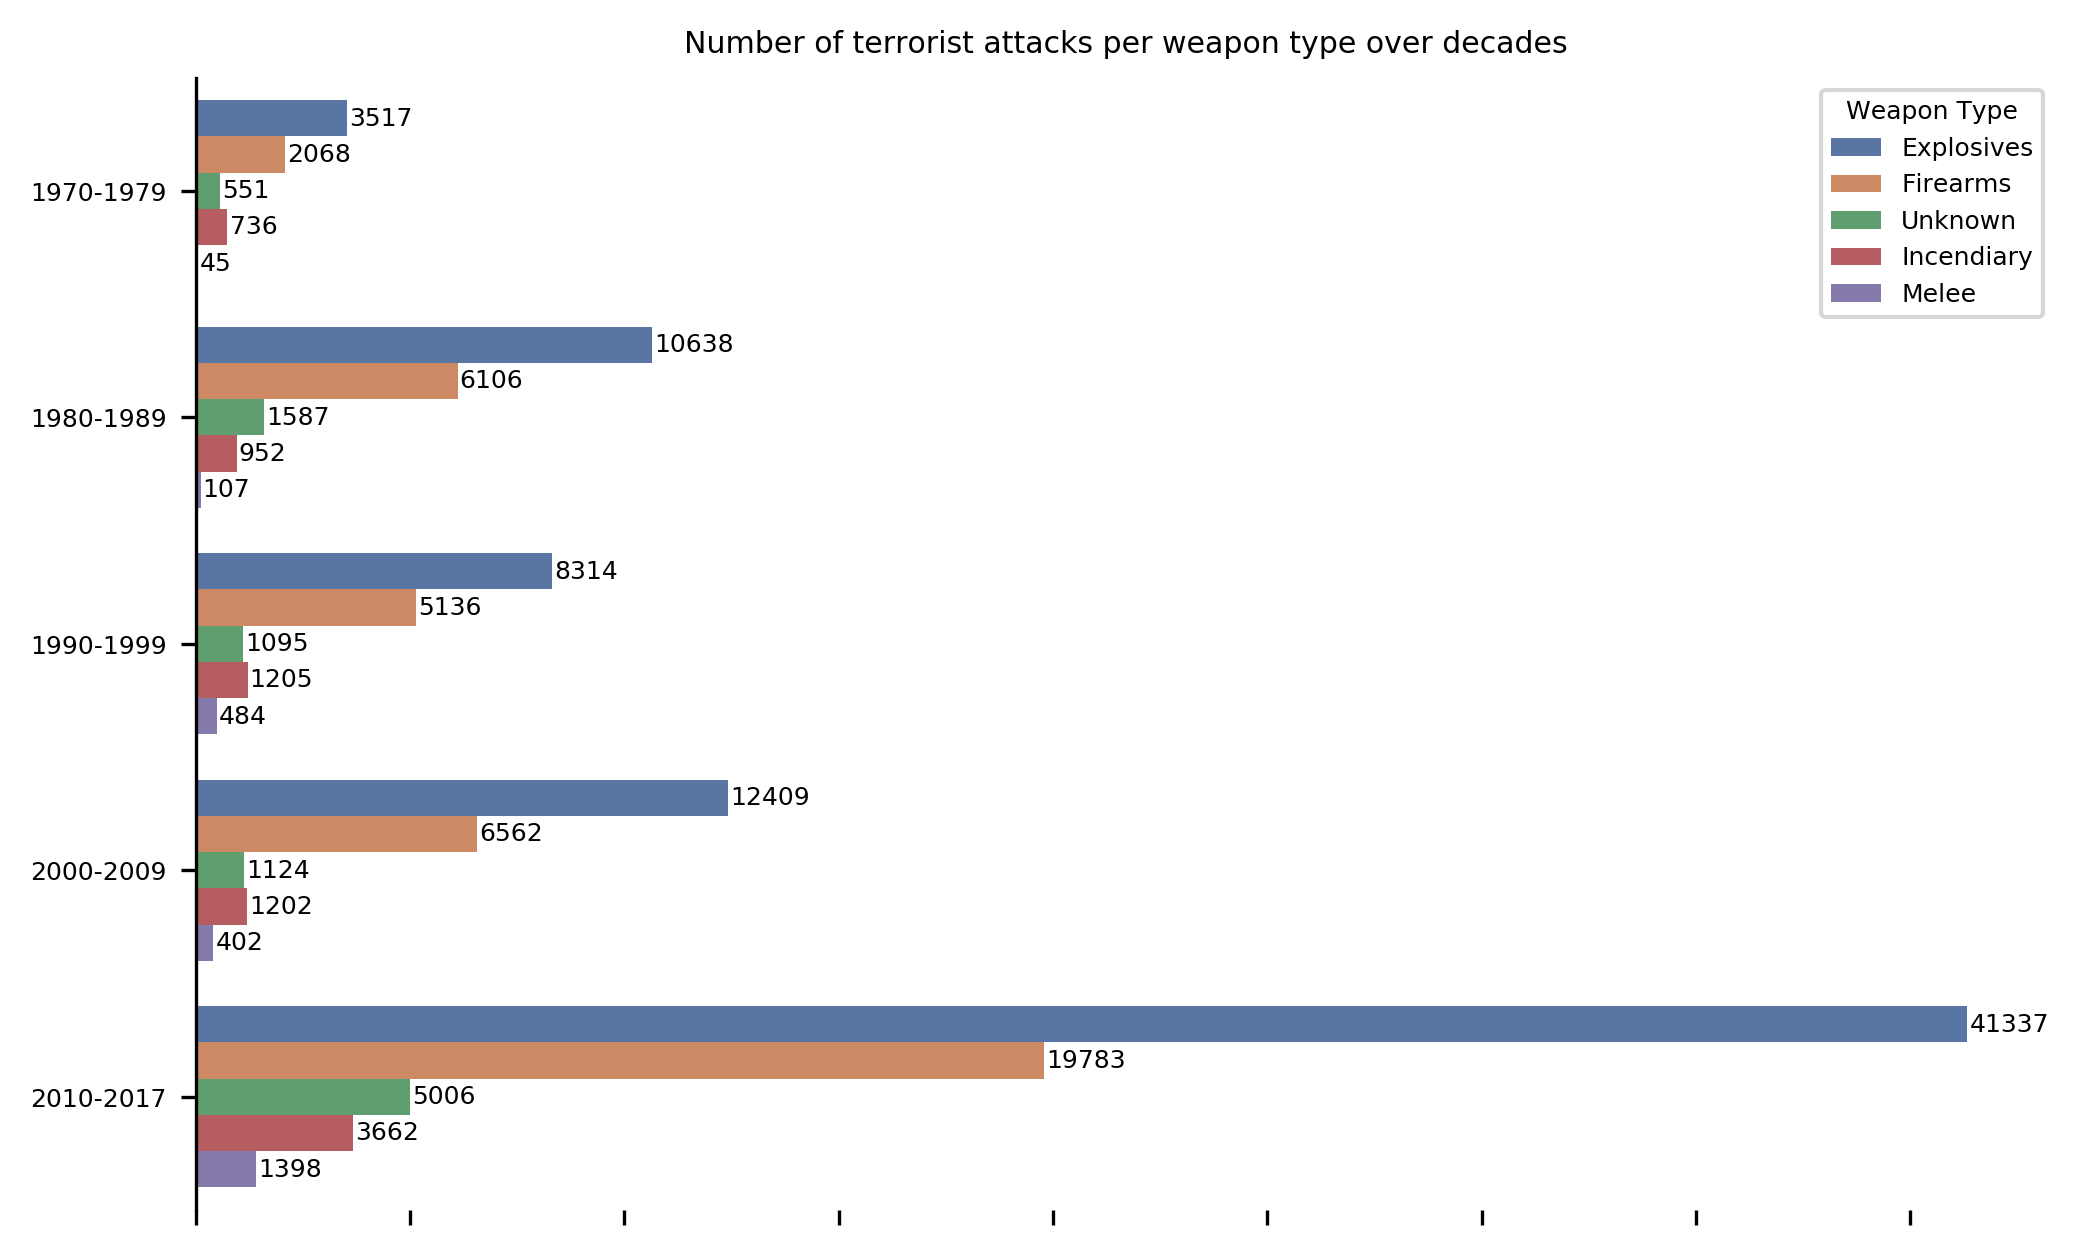

In [423]:
# filter for top 5 used weapon types
weapon_top_5 = weaptype_count['Weapon Type'].head(5).tolist()
weapon_trend_top5 = weapon_trend[(weapon_trend['Weapon Type'].isin(weapon_top_5))]

# create bar plot
fig, ax = plt.subplots(figsize = (8, 5), dpi=300)

plt.rcParams.update({'font.size': 6})

sns.barplot(data=weapon_trend_top5,x='Attack Count', y='Decade', hue='Weapon Type', palette='deep')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_title('Number of terrorist attacks per weapon type over decades')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

X2 = np.arange(5)

# add annotation for each hue
for s, d in zip(X2, weapon_trend_top5.loc[0:5,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s], xy = (d+50,s-0.29), color='black')
    
for s, d in zip(X2, weapon_trend_top5.loc[5:10,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s+5], xy = (d+50,s-0.13), color='black')
    
for s, d in zip(X2, weapon_trend_top5.loc[10:15,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s+10], xy = (d+50,s+0.03), color='black')

for s, d in zip(X2, weapon_trend_top5.loc[15:20,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s+15], xy = (d+50,s+0.19), color='black')

for s, d in zip(X2, weapon_trend_top5.loc[20:25,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s+20], xy = (d+50,s+0.35), color='black')

for s, d in zip(X2, weapon_trend_top5.loc[25:30,'Attack Count']):
    plt.annotate(weapon_trend_top5['Attack Count'][s+25], xy = (d+50,s+0.35), color='black')

plt.savefig('attacks_per_weapon_type_over_decades.png', dpi=300)

In [381]:
# manuall import weapon type description in list
weapon_descr = [['Biological','A weapon whose components are produced from pathogenic microorganisms or toxic substances of biological origins.'],
                ['Chemical','A weapon produced from toxic chemicals that is contained in a delivery system and dispersed as a liquid, vapor, or aerosol. This category includes chemical weapons delivered via explosive device.'],
                ['Radiological','A weapon whose components are produced from radioactive materials that emit ionizing radiation and can take many forms.'],
                ['Nuclear','A weapon which draws its explosive force from fission, fusion, or a combination of these methods.'],
                ['Firearms','A weapon which is capable of firing a projectile using an explosive charge as a propellant.'],
                ['Explosives','A weapon composed of energetically unstable material undergoing rapid decomposition and releasing a pressure wave that causes physical damage to the surrounding environment. Note that chemical weapons delivered via explosive are classified as Chemical with weapon subtype Explosives.'],
                ['Fake Weapons','A weapon that was claimed by the perpetrator at the time of the incident to be real but was discovered after-the-fact to be non-existent or incapable of producing the desired effects.'],
                ['Incendiary','A weapon that is capable of catching fire, causing fire, or burning readily and produces intensely hot fire when exploded.'],
                ['Melee','A weapon—targeting people rather than property—that does not involve a projectile in which the user and target are in contact with it simultaneously.'],
                ['Vehicle','An automobile that is used in an incident that does not incorporate the use of explosives such as a car bomb or truck bomb.'],
                ['Sabotage Equipment','A weapon that is used in the demolition or destruction of property (e.g., removing bolts from a train tracks).'],
                ['Other','A weapon that has been identified but does not fit into one of the above categories.'],
                ['Unknown','The weapon type cannot be determined from the available information.']]

In [421]:
# table of weapon type description
weapon_descr = pd.DataFrame(weapon_descr, columns=['Weapon Type','Description'])
pd.set_option('display.max_colwidth', -1)
weapon_descr.style.set_properties(**{'text-align': 'left'}, inplaces=True)

,Weapon Type,Description
0,Biological,A weapon whose components are produced from pathogenic microorganisms or toxic substances of biological origins.
1,Chemical,"A weapon produced from toxic chemicals that is contained in a delivery system and dispersed as a liquid, vapor, or aerosol. This category includes chemical weapons delivered via explosive device."
2,Radiological,A weapon whose components are produced from radioactive materials that emit ionizing radiation and can take many forms.
3,Nuclear,"A weapon which draws its explosive force from fission, fusion, or a combination of these methods."
4,Firearms,A weapon which is capable of firing a projectile using an explosive charge as a propellant.
5,Explosives,A weapon composed of energetically unstable material undergoing rapid decomposition and releasing a pressure wave that causes physical damage to the surrounding environment. Note that chemical weapons delivered via explosive are classified as Chemical with weapon subtype Explosives.
6,Fake Weapons,A weapon that was claimed by the perpetrator at the time of the incident to be real but was discovered after-the-fact to be non-existent or incapable of producing the desired effects.
7,Incendiary,"A weapon that is capable of catching fire, causing fire, or burning readily and produces intensely hot fire when exploded."
8,Melee,A weapon—targeting people rather than property—that does not involve a projectile in which the user and target are in contact with it simultaneously.
9,Vehicle,An automobile that is used in an incident that does not incorporate the use of explosives such as a car bomb or truck bomb.
